# **Airfare Price Prediction**

Dennis Myasnyankin, Vannessa Salazar, and Christine Vu

Shiley-Marcos School of Engineering, University of San Diego

ADS 599: Capstone Project

Professor Ebrahim Tarshizi

December 11, 2023

***

## **Data Importing**

### **Import Libraries**

In [48]:
import pandas as pd
from pandas import json_normalize
from datetime import datetime
import zipfile
import io
import os
import json
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


### **Data Acquisition and Aggregation**

In [49]:
github_repo_url = 'https://github.com/VSbr22/Capstone/raw/main/data/jsons.zip'

# Fetch the zip file from the GitHub repository
response = requests.get(github_repo_url)
zip_file = BytesIO(response.content)

In [50]:
# Unzip the folder
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('your_unzipped_folder')

In [51]:
# List all JSON files in the 'jsons' subfolder
json_subfolder = os.path.join('your_unzipped_folder', 'jsons')
json_files = [file for file in os.listdir(json_subfolder) if file.endswith('.json')]

# Initialize an empty list for extracted data
out = []

# Iterate over each JSON file
for file_name in json_files:
    # Load JSON data
    with open(os.path.join(json_subfolder, file_name), 'r') as file:
        data = json.load(file)

    # Christines code for processing
    schedule_descs = data["groupedItineraryResponse"]["scheduleDescs"]
    leg_descs = data["groupedItineraryResponse"]["legDescs"]
    itinerary_groups = data["groupedItineraryResponse"]["itineraryGroups"]

    # Iterate over itinerary groups
    for group in itinerary_groups:
        itineraries = group.get("itineraries", [])
        departure_date = group["groupDescription"]["legDescriptions"][0]["departureDate"]
        departure_city = group["groupDescription"]["legDescriptions"][0]["departureLocation"]
        arrival_date = group["groupDescription"]["legDescriptions"][0].get("arrivalDate", departure_date)
        arrival_location = group["groupDescription"]["legDescriptions"][0]["arrivalLocation"]

        # Calculate "Days Until Departure" based on current date and departure date
        current_date = datetime.now()
        departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
        days_until_departure = (departure_date - current_date).days

        # Iterate over itineraries in the group
        for itinerary in itineraries:
            legs = itinerary.get("legs", [])
            for leg in legs:
                schedules = leg_descs[leg.get('ref') - 1].get("schedules", [])
                for schedule in schedules:
                    schedule_data = schedule_descs[schedule.get('ref') - 1]

                    departure_time = schedule_data["departure"]["time"].split("+")[0]
                    arrival_time = schedule_data["arrival"]["time"].split("+")[0]
                    flight_duration = schedule_data["elapsedTime"]
                    operating_carrier = schedule_data["carrier"]["operating"]
                    aircraft_type = schedule_data["carrier"]["equipment"]["code"]
                    cabin_class = itinerary["pricingInformation"][0]["fare"]["passengerInfoList"][0]["passengerInfo"]["fareComponents"][0]["segments"][0]["segment"]["cabinCode"]
                    fare_class = itinerary["pricingInformation"][0]["fare"]["passengerInfoList"][0]["passengerInfo"]["fareComponents"][0]["segments"][0]["segment"]["bookingCode"]
                    price = itinerary["pricingInformation"][0]["fare"]["totalFare"]["totalPrice"]

                    # Add to output
                    out.append([
                        departure_city, departure_date, departure_time,
                        arrival_location, arrival_date, arrival_time,
                        flight_duration, operating_carrier, aircraft_type,
                        cabin_class, fare_class, price, days_until_departure
                    ])

# Creating a DataFrame
columns = [
    "Departure City", "Departure Date", "Departure Time",
    "Arrival Location", "Arrival Date", "Arrival Time",
    "Flight Duration", "Operating Carrier", "Aircraft Type",
    "Cabin Class", "Fare Class", "Price", "Days Until Departure"
]

df = pd.DataFrame(out, columns=columns)
df

,Departure City,Departure Date,Departure Time,Arrival Location,Arrival Date,Arrival Time,Flight Duration,Operating Carrier,Aircraft Type,Cabin Class,Fare Class,Price,Days Until Departure
0,ZRH,2023-11-22,06:50:00,LHR,2023-11-22,07:45:00Z,115,BA,319,Y,N,134.7,-7
1,ZRH,2023-11-22,07:10:00,LHR,2023-11-22,08:05:00Z,115,LX,32Q,Y,W,283.5,-7
2,ZRH,2023-11-22,10:20:00,LHR,2023-11-22,11:20:00Z,120,2L,295,Y,W,283.5,-7
3,ZRH,2023-11-22,15:30:00,LHR,2023-11-22,16:20:00Z,110,2L,295,Y,W,283.5,-7
4,ZRH,2023-11-22,17:05:00,LHR,2023-11-22,17:50:00Z,105,LX,32N,Y,W,283.5,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8190,IST,2023-11-15,12:50:00,IKA,2023-11-15,16:25:00,185,TK,32B,Y,L,233.6,-14
8191,IST,2023-11-15,06:00:00,IKA,2023-11-15,09:40:00,190,TK,32B,Y,L,233.6,-14
8192,IST,2023-11-15,08:05:00,IKA,2023-11-15,11:40:00,185,TK,7M8,Y,L,233.6,-14
8193,IST,2023-11-15,03:05:00,IKA,2023-11-15,06:35:00,180,TK,333,Y,O,403.6,-14


***

## **Exploratory Data Analysis**

In [52]:
# Check data type of features
df.dtypes

Departure City                  object
Departure Date          datetime64[ns]
Departure Time                  object
Arrival Location                object
Arrival Date                    object
Arrival Time                    object
Flight Duration                  int64
Operating Carrier               object
Aircraft Type                   object
Cabin Class                     object
Fare Class                      object
Price                          float64
Days Until Departure             int64
dtype: object

In [53]:
# Key statistics of studied variables
df.describe()

,Flight Duration,Price,Days Until Departure
count,8195.000000,8195.000000,8195.000000
mean,149.657474,397.953963,-1.194875
std,108.207384,520.505156,12.903113
min,45.000000,30.300000,-14.000000
25%,80.000000,165.950000,-14.000000
50%,110.000000,253.980000,-7.000000
75%,165.000000,413.500000,16.000000
max,545.000000,9920.800000,16.000000


In [54]:
print("DataFrame Shape:", df.shape)

DataFrame Shape: (8195, 13)


### **Itinerary Counts by Departure Date**

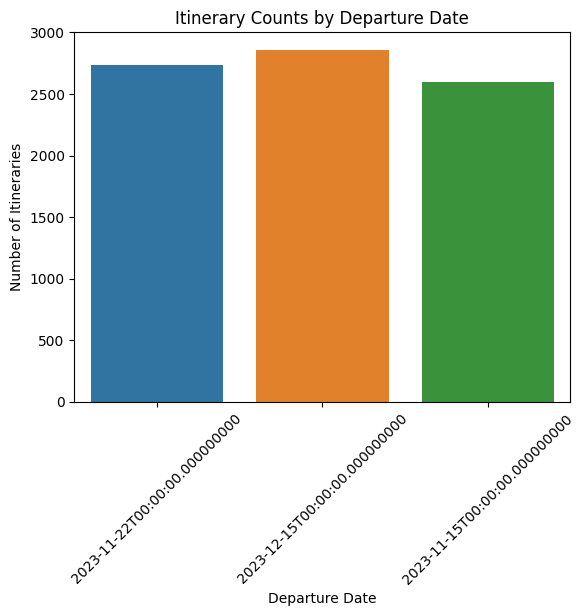

In [55]:
sns.countplot(x = 'Departure Date', data = df)
plt.title('Itinerary Counts by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Number of Itineraries')
plt.xticks(rotation = 45)
plt.show()

### **Price vs. Days Until Departure**

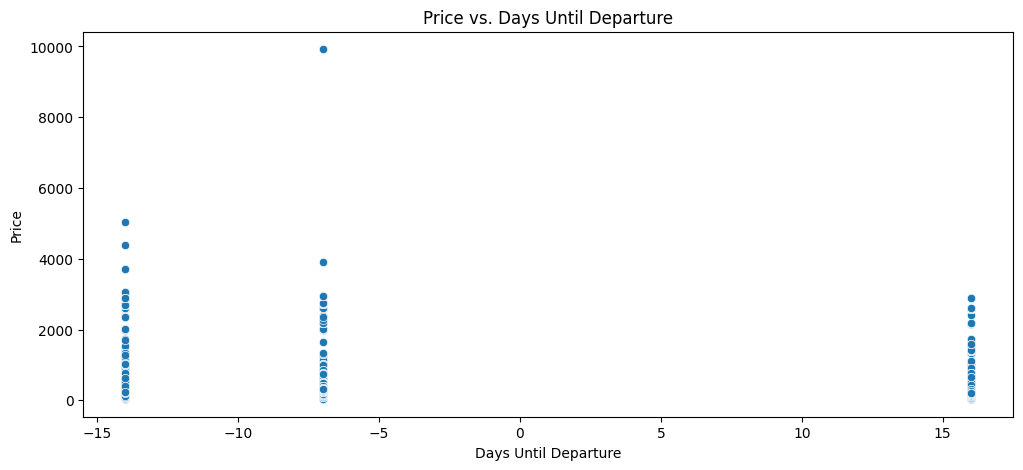

In [56]:
plt.figure(figsize = (12, 5))
sns.scatterplot(x = 'Days Until Departure', y = 'Price', data = df)
plt.title('Price vs. Days Until Departure')
plt.xlabel('Days Until Departure')
plt.ylabel('Price')
plt.show()

### **Average Price by Departure Date**

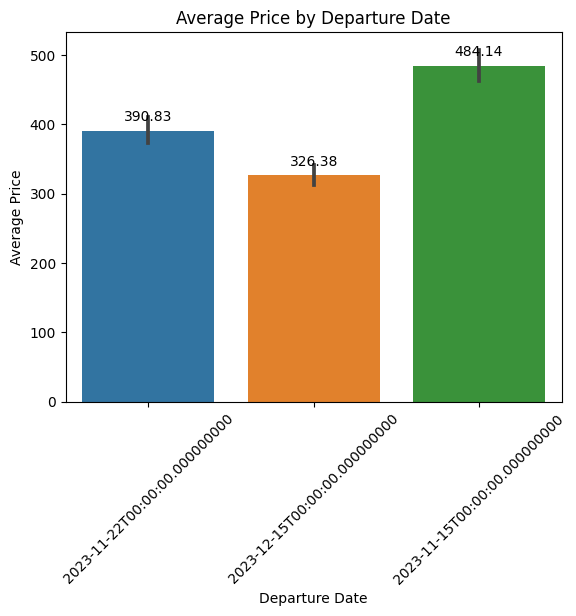

In [57]:
# Your existing code for plotting
barplot = sns.barplot(x = 'Departure Date', y = 'Price', data = df)
plt.title('Average Price by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Average Price')
plt.xticks(rotation = 45)

# Adding labels on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')

plt.show()

### **Distribution of Categorical Features**

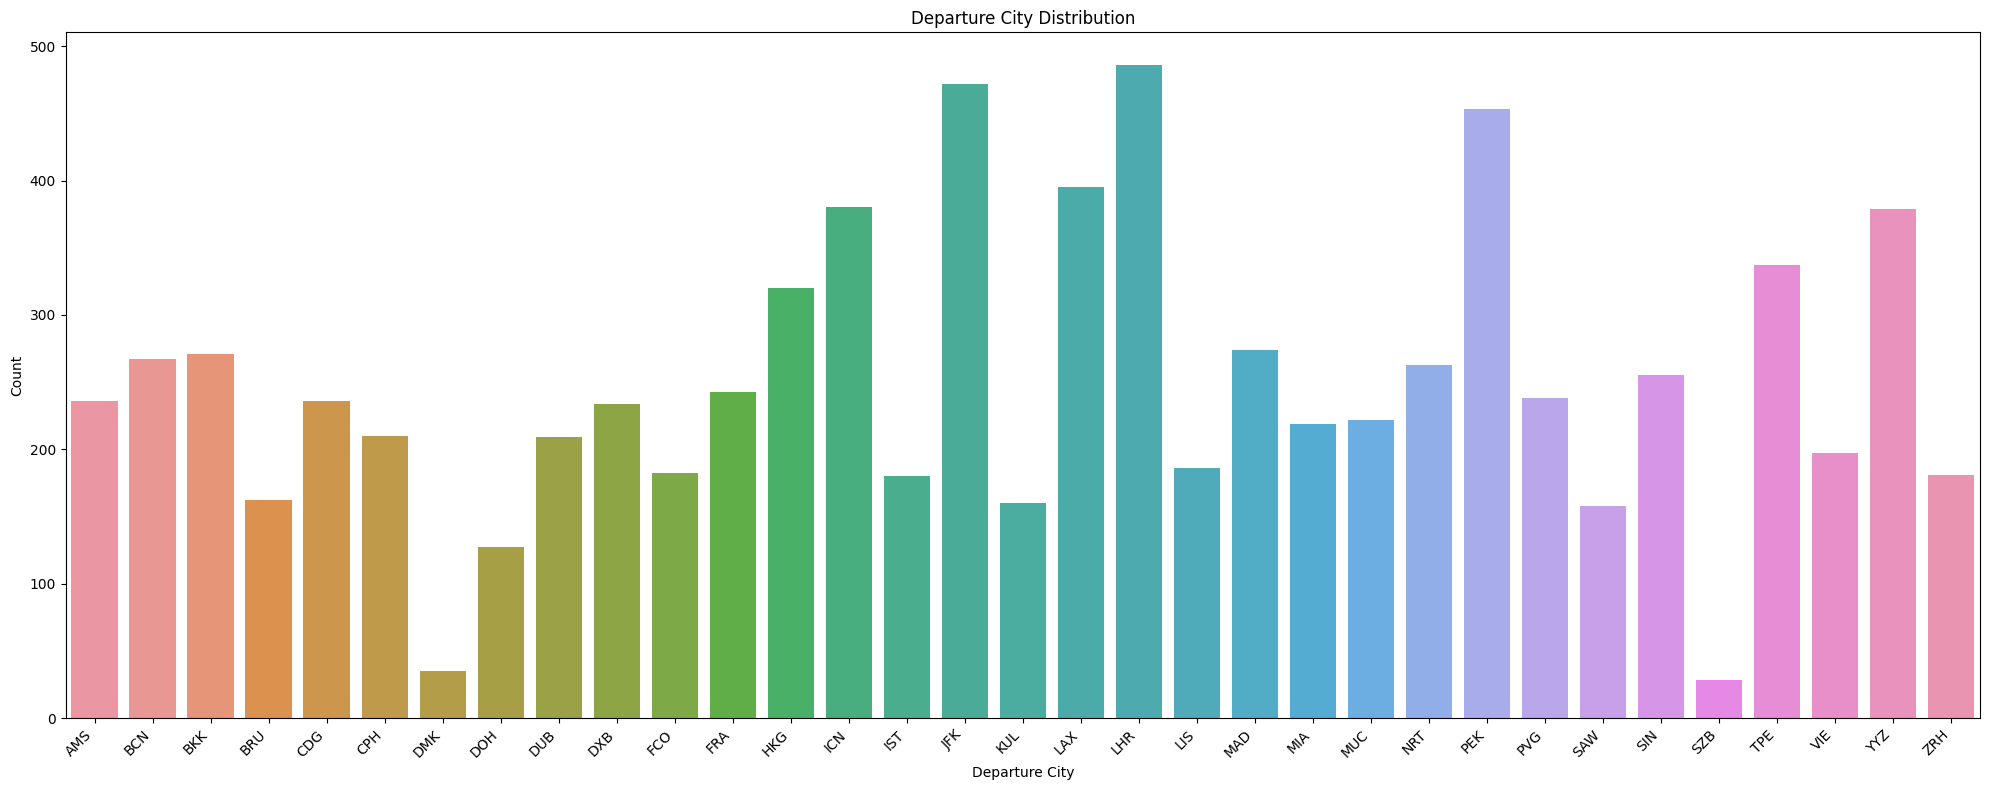

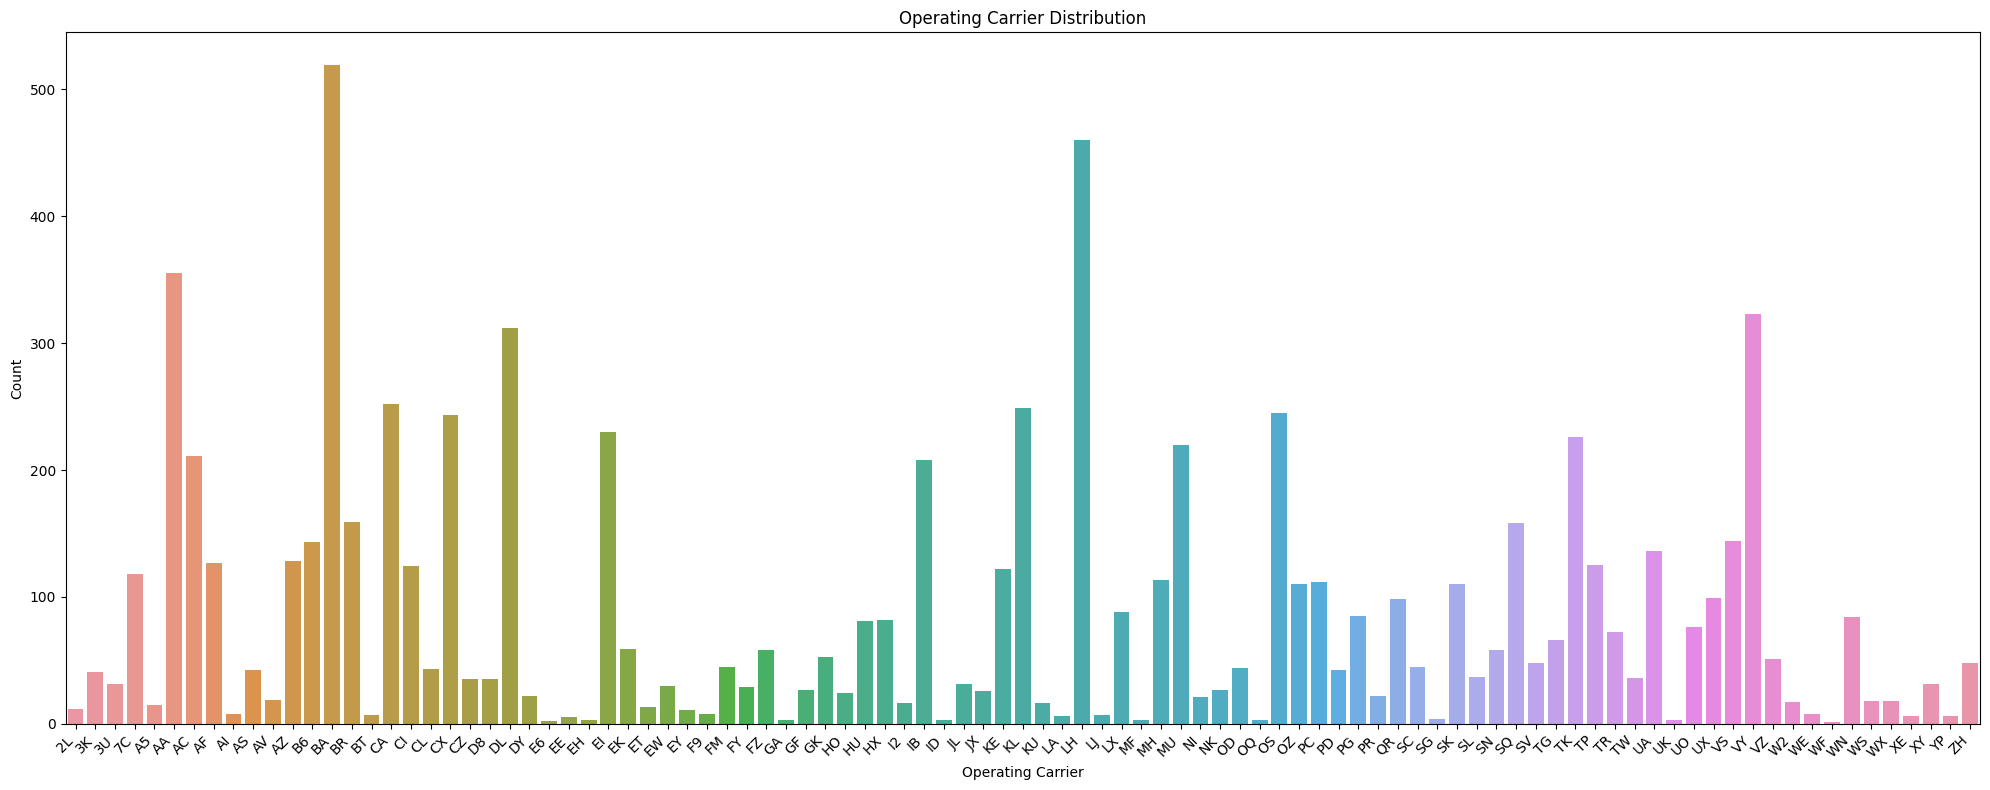

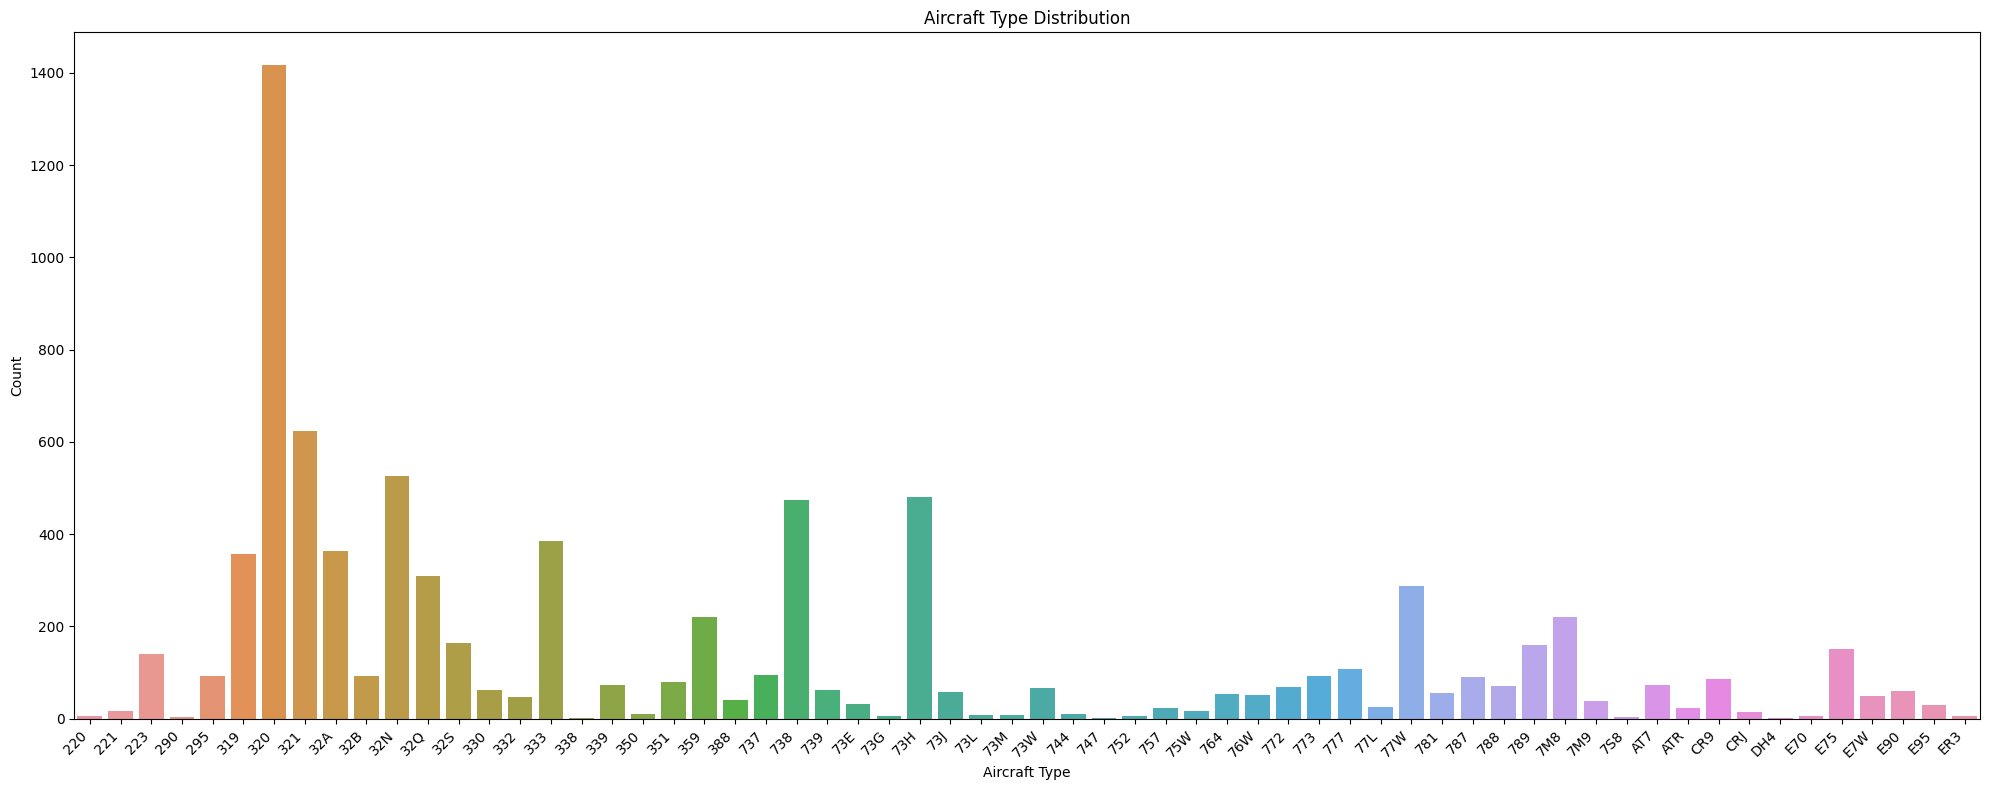

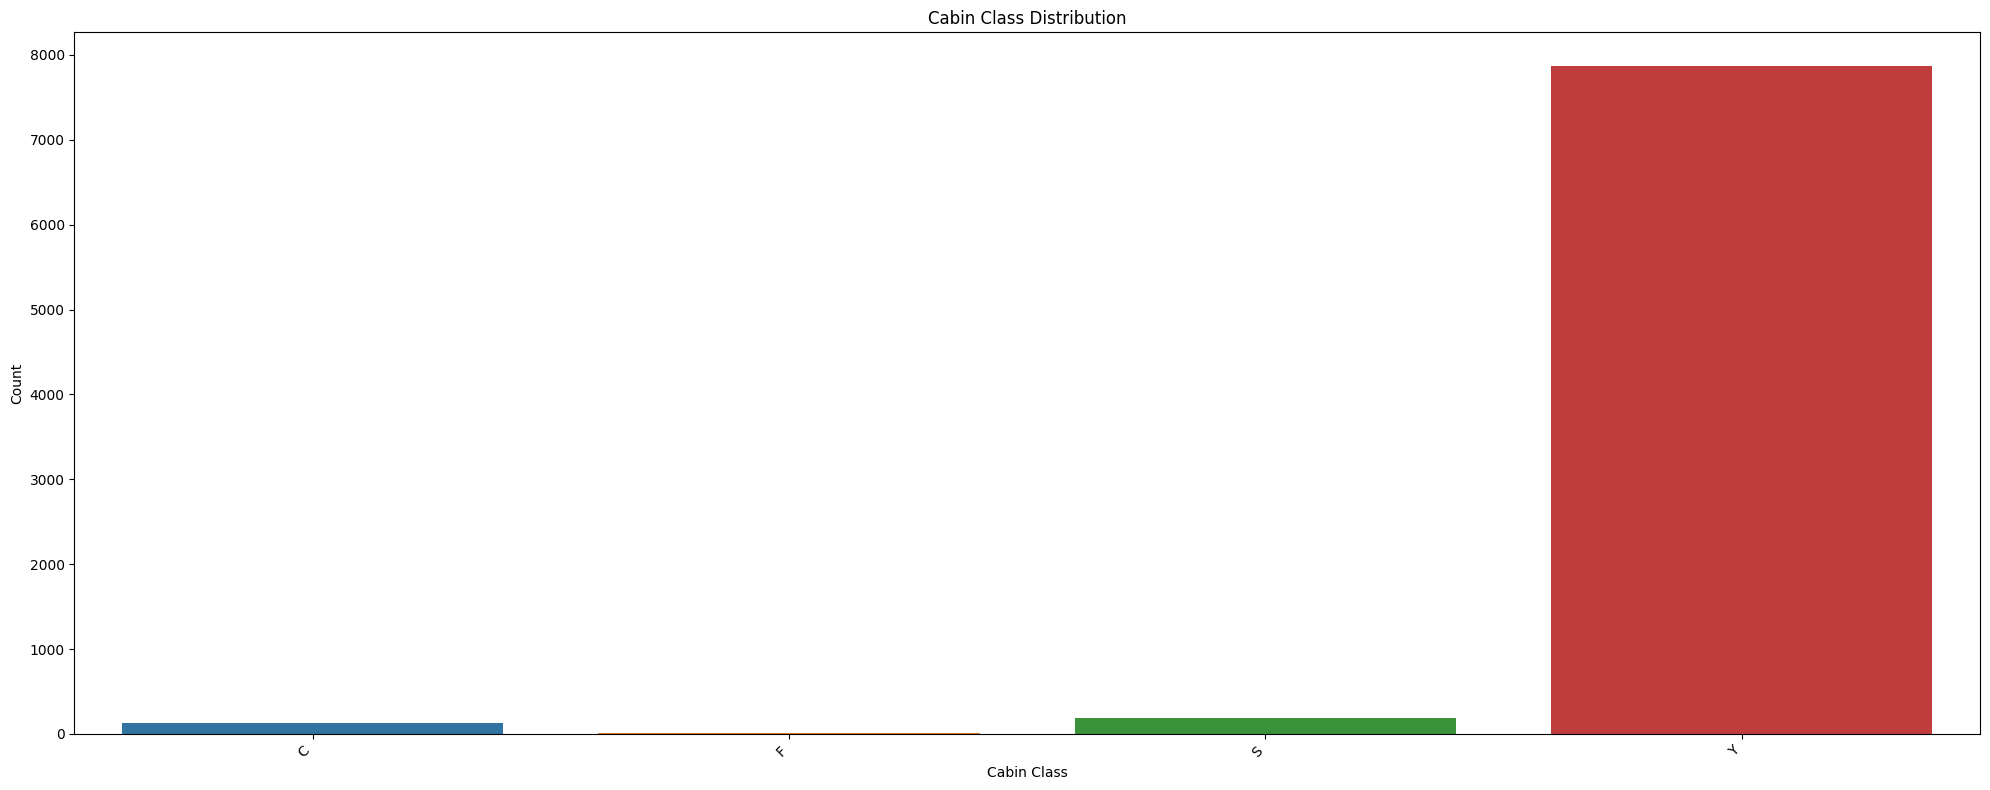

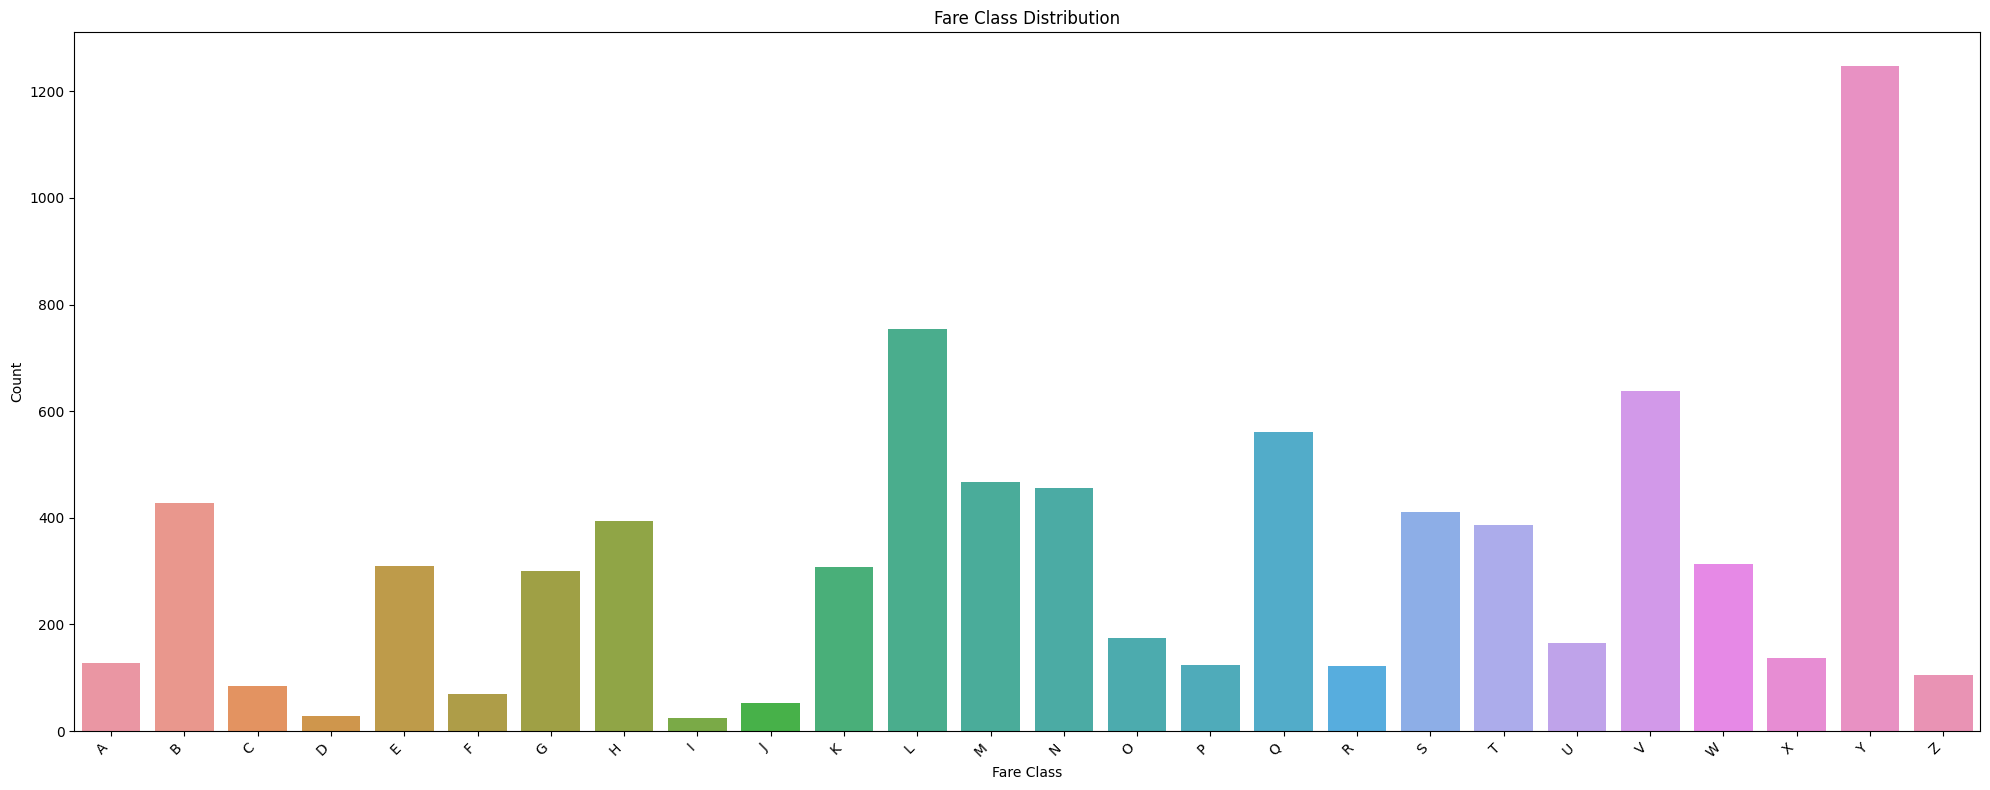

In [58]:
categorical_columns = ['Departure City', 'Operating Carrier', 'Aircraft Type', 'Cabin Class', 'Fare Class']

for column in categorical_columns:
    plt.figure(figsize = (20, 8))
    sns.countplot(x = column, data=df, order = sorted(df[column].unique()))
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.show()

### **Distribution of Numerical Features**

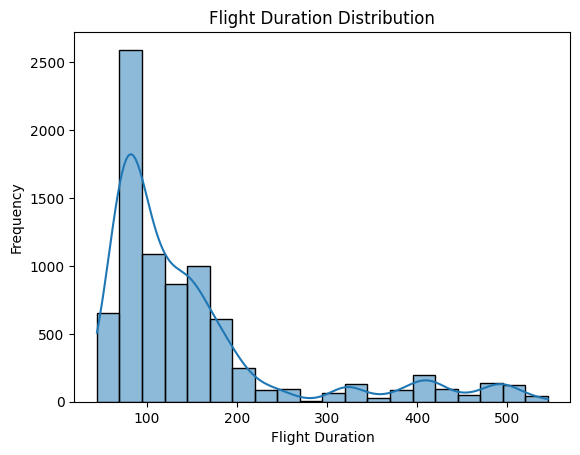

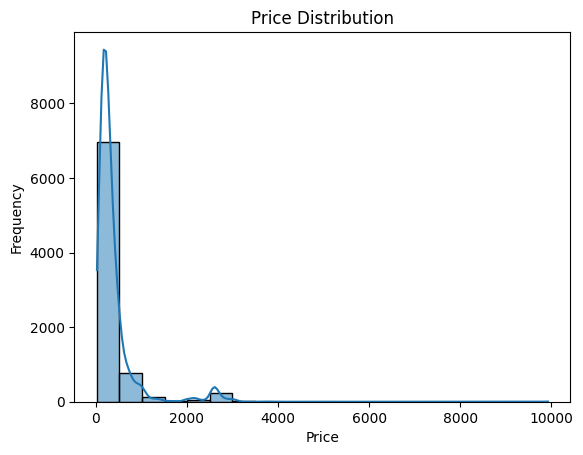

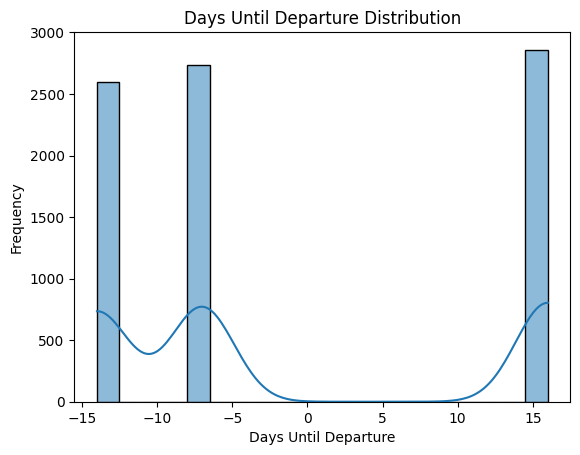

In [59]:
numerical_columns = df.select_dtypes(include = ['float64', 'int64']).columns

for column in numerical_columns:
    sns.histplot(df[column], kde = True, bins = 20)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

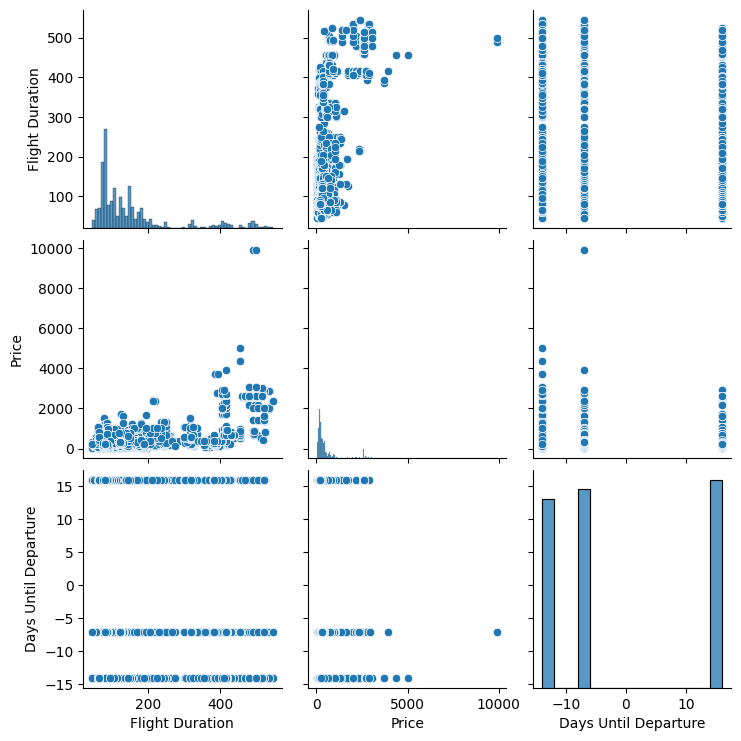

In [60]:
sns.pairplot(df[numerical_columns])
plt.show()

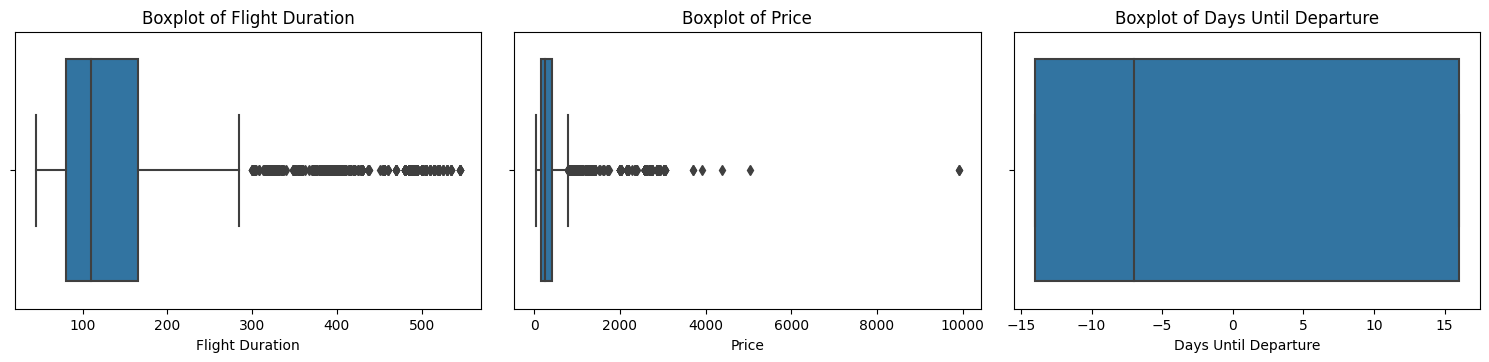

In [61]:
# Create boxplots for each numerical column
plt.figure(figsize = (15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = df[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

### **Average Price by Departure City**

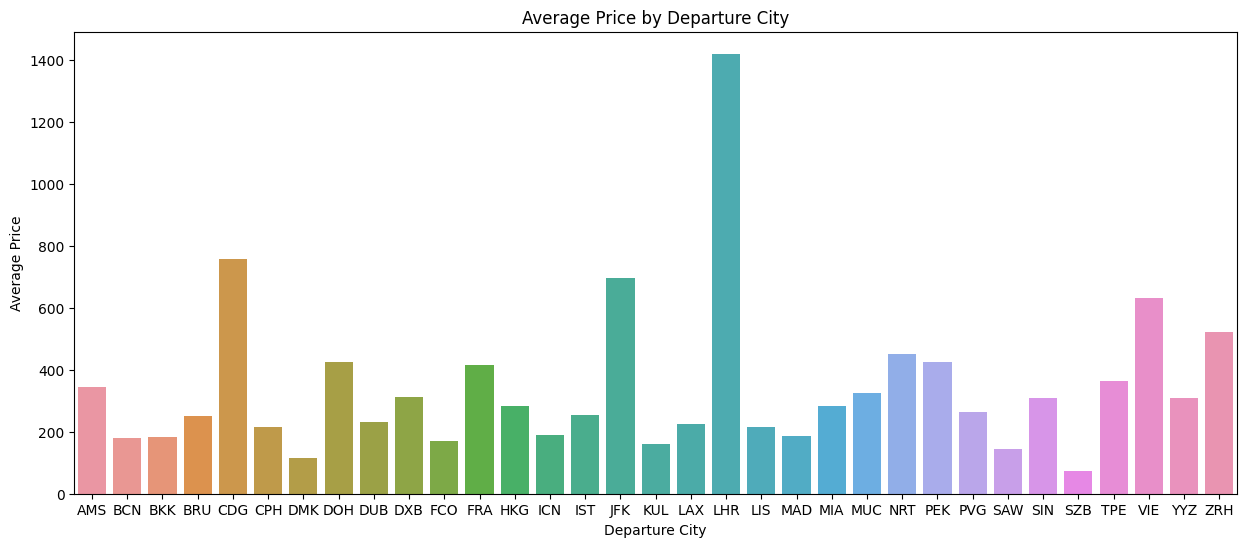

In [62]:
# Group by Departure City and calculate the mean for numerical columns
hub_stats = df.groupby('Departure City').agg({
    'Price': 'mean',
    'Flight Duration': 'mean',
}).reset_index()

# Average Cost by Departure City
plt.figure(figsize = (15, 6))
sns.barplot(x = 'Departure City', y = 'Price', data = hub_stats)
plt.title('Average Price by Departure City')
plt.xlabel('Departure City')
plt.ylabel('Average Price')
plt.show()

### **Average Flight Duration by Departure City**

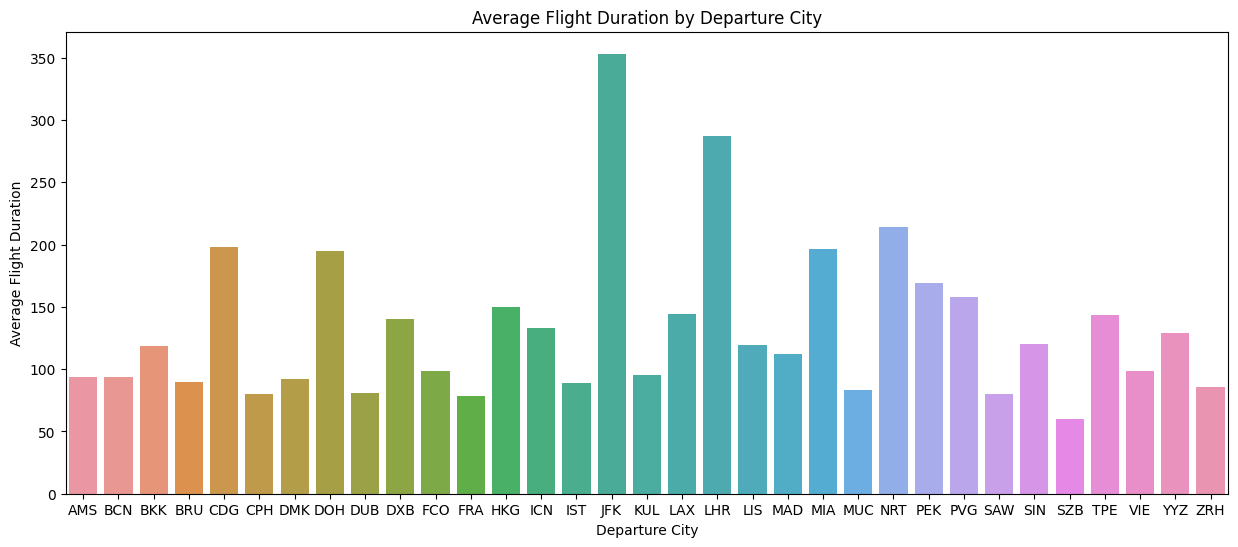

In [63]:
plt.figure(figsize = (15, 6))
sns.barplot(x = 'Departure City', y = 'Flight Duration', data = hub_stats)
plt.title('Average Flight Duration by Departure City')
plt.xlabel('Departure City')
plt.ylabel('Average Flight Duration')
plt.show()

### **Average Price and Flight Duration by Departure City**

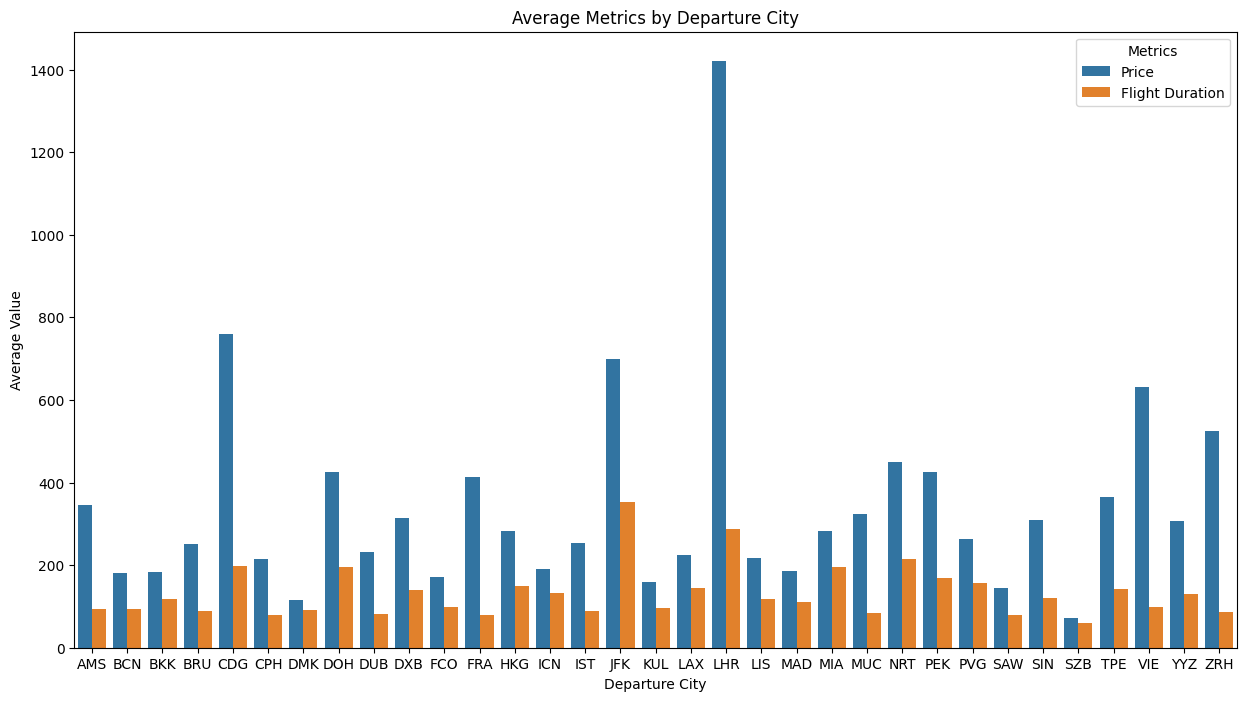

In [64]:
# Melt the dataframe to create a long-format dataframe for stacked bar chart
hub_stats_melted = hub_stats.melt(id_vars = 'Departure City', var_name = 'Metric', value_name = 'Value')

# Stacked bar chart for average cost, distance, and flight duration by departure city
plt.figure(figsize = (15, 8))
sns.barplot(x = 'Departure City', y = 'Value', hue = 'Metric', data = hub_stats_melted)
plt.title('Average Metrics by Departure City')
plt.xlabel('Departure City')
plt.ylabel('Average Value')
plt.legend(title = 'Metrics', loc = 'upper right')
plt.show()

### **Flight Duration by Operating Carrier**

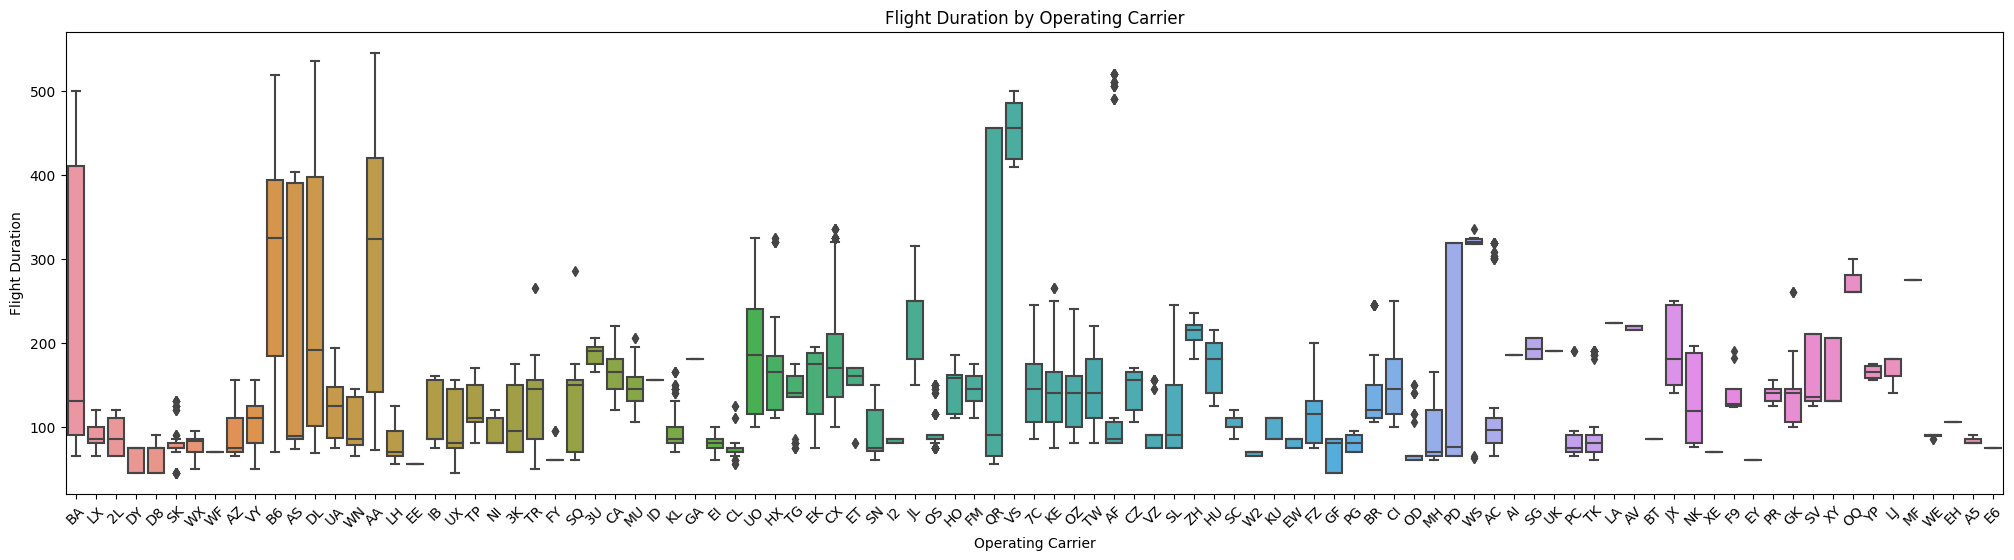

In [65]:
plt.figure(figsize = (25, 6))
sns.boxplot(x = 'Operating Carrier', y = 'Flight Duration', data = df)
plt.title('Flight Duration by Operating Carrier')
plt.xlabel('Operating Carrier')
plt.ylabel('Flight Duration')
plt.xticks(rotation = 45)
plt.show()

### **Flight Duration by Fare Class**

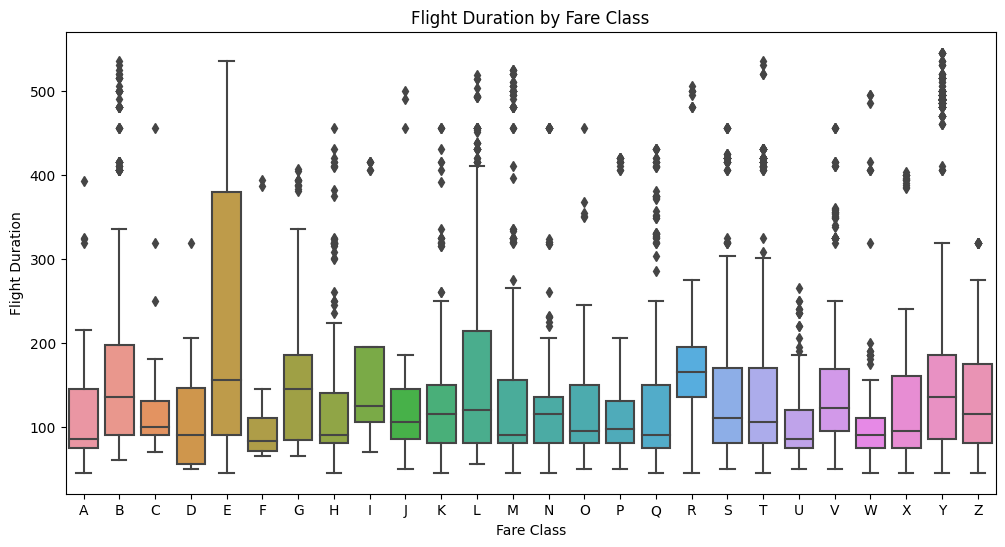

In [66]:
# Get the unique values of 'Fare Class' in alphabetical order
fare_class_order = sorted(df['Fare Class'].unique())

plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Fare Class', y = 'Flight Duration', data = df, order = fare_class_order)
plt.title('Flight Duration by Fare Class')
plt.xlabel('Fare Class')
plt.ylabel('Flight Duration')
plt.show()

### **Distribution of Fare Class by Departure Date**

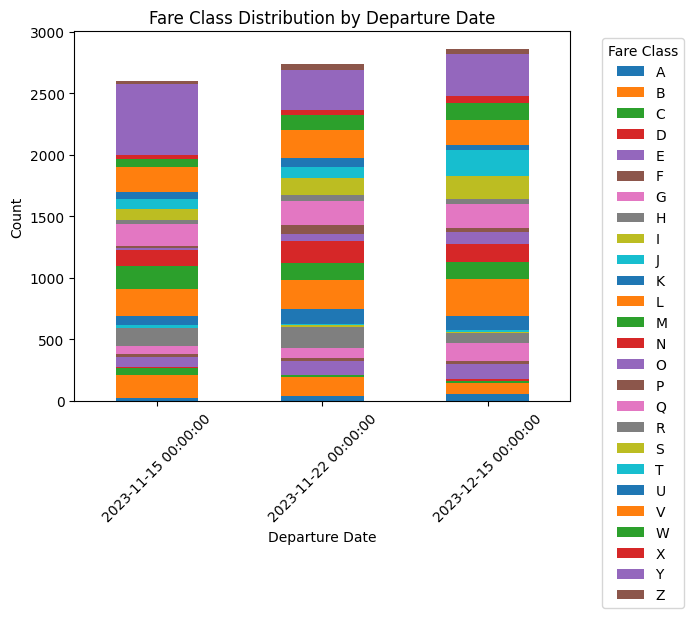

In [67]:
# Create a stacked dataframe
stacked_df = df.groupby(['Departure Date', 'Fare Class']).size().unstack()

# Plot stacked bar chart
stacked_df.plot(kind = 'bar', stacked = True)
plt.title('Fare Class Distribution by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.legend(title = 'Fare Class', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

### **Heatmap of Numerical Features**

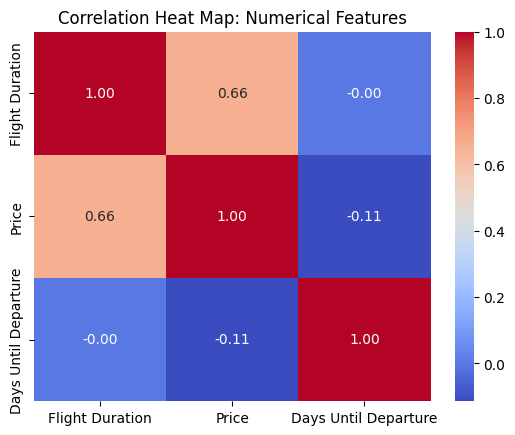

In [68]:
heatmap_data = df[numerical_columns]
sns.heatmap(heatmap_data.corr(), annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Correlation Heat Map: Numerical Features')
plt.show()

***

## **Data Preprocessing**

### **Handling Missing Values**

In [69]:
# Check for missing values
df.isnull().sum()

Departure City          0
Departure Date          0
Departure Time          0
Arrival Location        0
Arrival Date            0
Arrival Time            0
Flight Duration         0
Operating Carrier       0
Aircraft Type           0
Cabin Class             0
Fare Class              0
Price                   0
Days Until Departure    0
dtype: int64

There is no missing data, so there is no need for imputation or removal.


In [70]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicate rows (if any exist)
df.drop_duplicates(inplace = True)

Number of duplicate rows: 399


### **One Hot Encoding: Handling Categorical Features**

In [71]:
df = pd.get_dummies(df, columns = categorical_columns)

### **Outliers: Remove Using Z-Score**

Rows from the original dataframe where all the z-scores are less than 3 are selected. Rows with z-scores greater than 3 are considered outliers and are excluded from the new dataframe.

In [72]:
z_scores = stats.zscore(df[numerical_columns])
df_no_outliers = df[(z_scores < 3)]

### **Convert to DateTime Format**

In [73]:
df['Departure Time'] = df['Departure Time'].str.replace('Z', '', regex = False)
df['Arrival Time'] = df['Arrival Time'].str.replace('Z', '', regex = False)

In [83]:
df['Departure Date'] = pd.to_datetime(df['Departure Date'], errors='coerce')
df['Departure Time'] = pd.to_datetime(df['Departure Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S', utc=True)
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'], errors='coerce')
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S', utc =True)

In [84]:
print(df['Arrival Time'])

0      2023-11-28 07:45:00+00:00
1      2023-11-28 08:05:00+00:00
2      2023-11-28 11:20:00+00:00
3      2023-11-28 16:20:00+00:00
4      2023-11-28 17:50:00+00:00
                  ...           
8190   2023-11-28 16:25:00+00:00
8191   2023-11-28 09:40:00+00:00
8192   2023-11-28 11:40:00+00:00
8193   2023-11-28 06:35:00+00:00
8194   2023-11-28 03:10:00+00:00
Name: Arrival Time, Length: 7796, dtype: datetime64[ns, UTC]


In [85]:
print(df['Departure Time'])

0      2023-11-28 06:50:00+00:00
1      2023-11-28 07:10:00+00:00
2      2023-11-28 10:20:00+00:00
3      2023-11-28 15:30:00+00:00
4      2023-11-28 17:05:00+00:00
                  ...           
8190   2023-11-28 12:50:00+00:00
8191   2023-11-28 06:00:00+00:00
8192   2023-11-28 08:05:00+00:00
8193   2023-11-28 03:05:00+00:00
8194   2023-11-28 23:30:00+00:00
Name: Departure Time, Length: 7796, dtype: datetime64[ns, UTC]


In [86]:
df.dtypes

Departure Date           datetime64[ns]
Departure Time      datetime64[ns, UTC]
Arrival Location                 object
Arrival Date             datetime64[ns]
Arrival Time        datetime64[ns, UTC]
                           ...         
Fare Class_V                      uint8
Fare Class_W                      uint8
Fare Class_X                      uint8
Fare Class_Y                      uint8
Fare Class_Z                      uint8
Length: 230, dtype: object